<a href="https://colab.research.google.com/github/tushar-marine/colon_cancer/blob/main/Xception_colon_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Adding Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##**Moving to working directory** 

In [ ]:
import os
os.chdir('/content/drive/MyDrive/Colab Notebooks/thesis')
!ls

'~'				  VGG16_colon_cancer.ipynb
 InceptionV3_colon_cancer.ipynb   VGG19_colon_cancer.ipynb
 ResNet50V2_colon_cancer.ipynb	  Xception_colon_cancer.ipynb


#**Importing required libraries**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#**Data Preprocessing**

##**Loading the data from form tensorflow_datasets**

In [ ]:
tfds.disable_progress_bar()

# Reserve 10% for validation and 10% for test
(train_ds, validation_ds, test_ds), info = tfds.load("colorectal_histology",
                                                     split=["train[:80%]", "train[80%:90%]", "train[90%:]"],
                                                     as_supervised=True,
                                                     with_info=True)

print("Number of training examples: %d" % tf.data.experimental.cardinality(train_ds))
print("Number of validation examples: %d" % tf.data.experimental.cardinality(validation_ds))
print("Number of test examples: %d" % tf.data.experimental.cardinality(test_ds))

num_classes = info.features['label'].num_classes
print("Number of classes: %d" % num_classes)

original_image_size = info.features['image'].shape
print(f"Original image size: {original_image_size}")


Number of training examples: 4000
Number of validation examples: 500
Number of test examples: 500
Number of classes: 8
Original image size: (150, 150, 3)


In [ ]:
# Get class names
class_names = info.features["label"].names
print(f"class names are: {class_names}")

class names are: ['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa', 'adipose', 'empty']


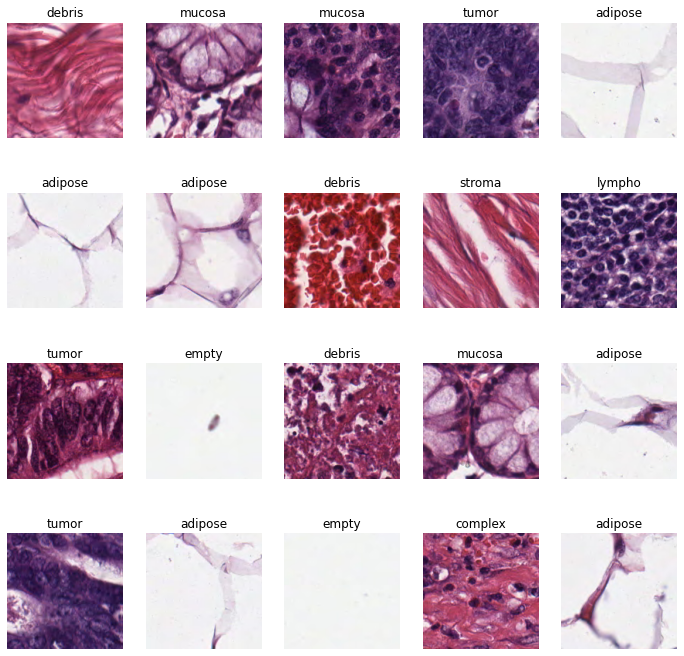

In [ ]:
plt.figure(figsize=(12, 12))
for i, (image, label) in enumerate(train_ds.take(20)):
    ax = plt.subplot(4, 5, i + 1)
    plt.imshow(image)
    plt.title(class_names[int(label)])
    plt.axis("off")

##**Standardizing the data**

In [ ]:
# Resizing the images
img_size = (150, 150)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))
test_ds = test_ds.map(lambda x, y: (tf.image.resize(x, img_size), y))

In [ ]:
# Batch, cache, and prefetch the data
batch_size = 32
train_ds = train_ds.cache().batch(batch_size).prefetch(buffer_size=5)
validation_ds = validation_ds.cache().batch(batch_size).prefetch(buffer_size=5)
test_ds = test_ds.cache().batch(batch_size).prefetch(buffer_size=5)

##**Random data augmentation**

In [ ]:
# Creating a data augmentation stage with horizontal flipping, rotations and zooms
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
], name ="data_augmentation")

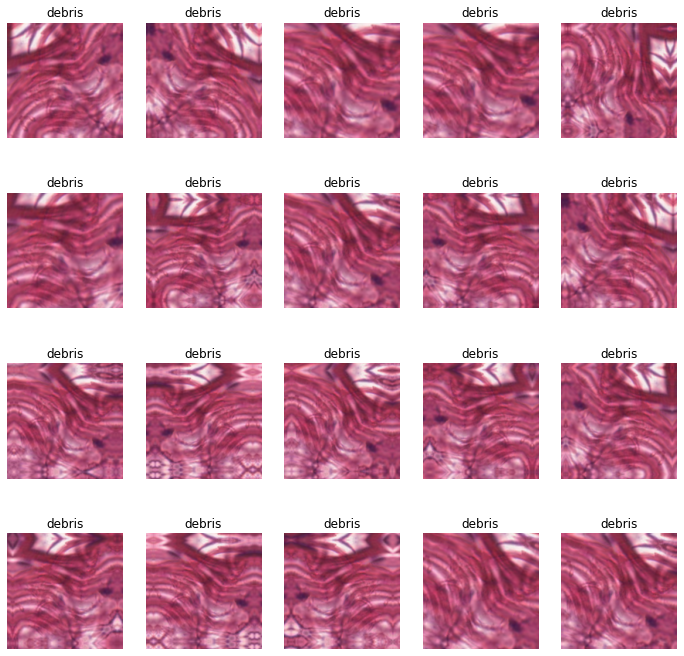

In [ ]:
# Visualizing the 1st image of the 1st batch after 20 random augmentation
for images, labels in train_ds.take(1):
    plt.figure(figsize=(12, 12))
    image = images[0]
    for i in range(20):
        ax = plt.subplot(4, 5, i + 1)
        aug_img = data_augmentation(tf.expand_dims(image, 0), training=True)
        plt.imshow(tf.squeeze(aug_img).numpy().astype("int32"))
        plt.title(class_names[int(labels[0])])
        plt.axis("off")

#**Building models**

##**Xception**

In [ ]:
from tensorflow.keras.applications import Xception

**Feature Extraction**

In [ ]:
# Setup input shape and base model
input_shape = img_size + (3, )
base_model = Xception(weights="imagenet", input_shape=input_shape, include_top=False)

# Freeze the base_model
base_model.trainable = False

# Create a new model on top
inputs = keras.Input(shape=input_shape, name="input_layer")

# Apply random data augmentation
x = data_augmentation(inputs)  

# Scaling input to a range of (-1., +1.) from (0, 255) 
x = keras.layers.Rescaling(scale=1/127.5, offset=-1)(x)

# Running the base_model in inference mode so that batchnorm statistics don't get updated even for fine-tuning.
x = base_model(x, training=False)

# Convert outputs of the base model to vectors
x = keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# Create the output activation layer
outputs = keras.layers.Dense(num_classes, activation="softmax", name="output_layer")(x)

# Combine the inputs with the outputs into a model
model = keras.Model(inputs, outputs)

model.summary()

83697664/83683744 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                              

In [ ]:
# Compiling Xception model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

# Fit the model
history_feature_extraction = model.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50
125/125 [==============================] - 313s 2s/step - loss: 0.9495 - accuracy: 0.7345 - val_loss: 0.6445 - val_accuracy: 0.8440
Epoch 2/50
125/125 [==============================] - 303s 2s/step - loss: 0.6383 - accuracy: 0.8487 - val_loss: 0.5332 - val_accuracy: 0.8840
Epoch 3/50
125/125 [==============================] - 310s 2s/step - loss: 0.5545 - accuracy: 0.8637 - val_loss: 0.4960 - val_accuracy: 0.8720
Epoch 4/50
125/125 [==============================] - 303s 2s/step - loss: 0.4885 - accuracy: 0.8775 - val_loss: 0.4600 - val_accuracy: 0.8720
Epoch 5/50
125/125 [==============================] - 302s 2s/step - loss: 0.4591 - accuracy: 0.8808 - val_loss: 0.4050 - val_accuracy: 0.8820
Epoch 6/50
125/125 [==============================] - 301s 2s/step - loss: 0.4195 - accuracy: 0.8890 - val_loss: 0.3983 - val_accuracy: 0.8920
Epoch 7/50
125/125 [==============================] - 302s 2s/step - loss: 0.4153 - accuracy: 0.8825 - val_loss: 0.3770 - val_accuracy: 0.8840

**Fine tuning the Xception**

In [ ]:
# Unfreeze the entire base model
base_model.trainable = True

# Freeze all layers except the last 10 layers
for layer in base_model.layers[:-10]:
  layer.trainable = False

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 150, 150, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 150, 150, 3)      0         
 al)                                                             
                                                                 
 rescaling (Rescaling)       (None, 150, 150, 3)       0         
                                                                 
 xception (Functional)       (None, 5, 5, 2048)        20861480  
                                                                 
 global_average_pooling_laye  (None, 2048)             0         
 r (GlobalAveragePooling2D)                                      
                                                                 
 output_layer (Dense)        (None, 8)                 16392 

In [ ]:
# Compile the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              metrics=["accuracy"])

# Fit the model
history_fine_tuning = model.fit(train_ds, epochs=50, validation_data=validation_ds)

Epoch 1/50
125/125 [==============================] - 376s 3s/step - loss: 0.1928 - accuracy: 0.9320 - val_loss: 0.2263 - val_accuracy: 0.9200
Epoch 2/50
125/125 [==============================] - 372s 3s/step - loss: 0.1752 - accuracy: 0.9373 - val_loss: 0.2208 - val_accuracy: 0.9240
Epoch 3/50
125/125 [==============================] - 372s 3s/step - loss: 0.1813 - accuracy: 0.9320 - val_loss: 0.2167 - val_accuracy: 0.9160
Epoch 4/50
125/125 [==============================] - 372s 3s/step - loss: 0.1671 - accuracy: 0.9392 - val_loss: 0.2122 - val_accuracy: 0.9240
Epoch 5/50
125/125 [==============================] - 372s 3s/step - loss: 0.1625 - accuracy: 0.9430 - val_loss: 0.2132 - val_accuracy: 0.9260
Epoch 6/50
125/125 [==============================] - 371s 3s/step - loss: 0.1620 - accuracy: 0.9435 - val_loss: 0.2150 - val_accuracy: 0.9320
Epoch 7/50
125/125 [==============================] - 371s 3s/step - loss: 0.1586 - accuracy: 0.9430 - val_loss: 0.2150 - val_accuracy: 0.9280

###**Evaluation**

**Loss Curve**

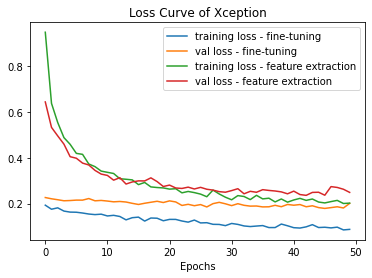

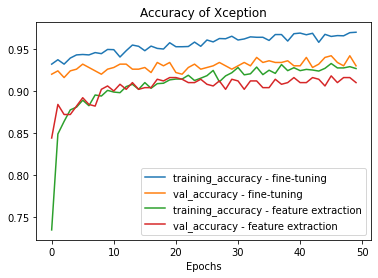

In [ ]:
# Comparing accuracy and loss curves for training and validation sets for feature extraction and fine-tuning 
loss_fn = history_fine_tuning.history['loss']
val_loss_fn = history_fine_tuning.history['val_loss']
accuracy_fn = history_fine_tuning.history['accuracy']
val_accuracy_fn = history_fine_tuning.history['val_accuracy']

loss_fe = history_feature_extraction.history['loss']
val_loss_fe = history_feature_extraction.history['val_loss']
accuracy_fe = history_feature_extraction.history['accuracy']
val_accuracy_fe = history_feature_extraction.history['val_accuracy']

epochs = range(len(history_fine_tuning.history['loss']))

# Plotting loss curve
plt.figure()
plt.plot(epochs, loss_fn, label='training loss - fine-tuning')
plt.plot(epochs, val_loss_fn, label='val loss - fine-tuning')
plt.plot(epochs, loss_fe, label='training loss - feature extraction')
plt.plot(epochs, val_loss_fe, label='val loss - feature extraction')
plt.title('Loss Curve of Xception')
plt.xlabel('Epochs')
plt.legend();

# Plotting accuracy
plt.figure()
plt.plot(epochs, accuracy_fn, label='training_accuracy - fine-tuning')
plt.plot(epochs, val_accuracy_fn, label='val_accuracy - fine-tuning')
plt.plot(epochs, accuracy_fe, label='training_accuracy - feature extraction')
plt.plot(epochs, val_accuracy_fe, label='val_accuracy - feature extraction')
plt.title('Accuracy of Xception')
plt.xlabel('Epochs')
plt.legend();

**Evaluating using the testing data**

In [ ]:
loss, accuracy = model.evaluate(test_ds, batch_size=32)
print(f"Model loss on test set: {(loss):.2f}")
print(f"Model accuracy on test set: {(accuracy*100):.2f}%")

16/16 [==============================] - 33s 2s/step - loss: 0.1872 - accuracy: 0.9480
Model loss on test set: 0.19
Model accuracy on test set: 94.80%


**Confusion Matrix**

In [ ]:
# Model prediction for test data
pred = model.predict(test_ds)

# Match the prediction class to the highest prediction probability
y_pred = [pred[i].argmax() for i in range(len(pred))]
y_pred_class = [class_names[y_pred[i]] for i in range(len(y_pred))]

# Extract the truth ground label and match to class_names 
y_true = np.concatenate([y for x, y in test_ds], axis=0)
y_true_class = [class_names[y_true[i]] for i in range(len(y_true))]

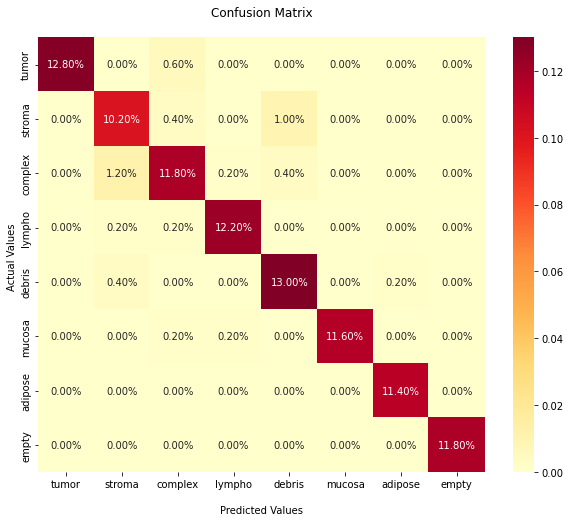

In [ ]:
# Plotting confusion matrix
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(cm/np.sum(cm),fmt='.2%', annot=True, cmap='YlOrRd')
ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(class_names)
ax.yaxis.set_ticklabels(class_names)
plt.show()

**Classification Report**

In [ ]:
print(classification_report(y_true_class, y_pred_class, digits=3))

              precision    recall  f1-score   support

     adipose      0.983     1.000     0.991        57
     complex      0.894     0.868     0.881        68
      debris      0.903     0.956     0.929        68
       empty      1.000     1.000     1.000        59
      lympho      0.968     0.968     0.968        63
      mucosa      1.000     0.967     0.983        60
      stroma      0.850     0.879     0.864        58
       tumor      1.000     0.955     0.977        67

    accuracy                          0.948       500
   macro avg      0.950     0.949     0.949       500
weighted avg      0.949     0.948     0.948       500

